### Load outputs from csv file

In [2]:
import SAM
import os
from styleTransfer import StyleTransferLinear, StyleTransferPartialConv
import utils
import numpy as np
import pandas as pd
import cv2

stylizer_ref = StyleTransferLinear(device="cuda")
stylizer = StyleTransferPartialConv(device="cuda")

sam_data_dir = "../SA-1B-Dataset/"
style_dir = "styles/"

style_ims = os.listdir(style_dir) 

df = pd.read_csv("outputs/style_transfer_metrics.csv")

### For each row in dataframe, rerun stylizer, display outputs to user to select best method

In [ ]:

for row in df.iterrows():

    # Load the content, style, and mask
    sam_json_path = os.path.join(sam_data_dir, df.iloc[row[0]]['content'])
    sam_image_path = os.path.join(sam_data_dir, df.iloc[row[0]]['content'].replace(".json", ".jpg"))
    
    if not os.path.exists(sam_image_path):
        continue
    
    content_im = utils.loadImage(sam_image_path)
    style_im = utils.loadImage(os.path.join(style_dir, df.iloc[row[0]]['style']))

    sam_json = SAM.loadMaskJSON(sam_json_path)
    mask_num =int(df.iloc[row[0]]['mask_num'])
    mask = SAM.loadIndices(sam_json, mask_num)[0]

    # Rerun the style options
    result_stm = stylizer_ref(content_im, style_im, mask)
    result_pc = stylizer(content_im, style_im, mask)

    # Convert to numpy for displaying
    mask_np = utils.tensorToMask(mask)
    style_np = utils.tensorToImage(style_im)
    result_stm_np = utils.tensorToImage(result_stm)
    result_pc_np = utils.tensorToImage(result_pc)

    # Show style, mask, and results side by side in openCV window
    mask_cv = cv2.cvtColor(mask_np, cv2.COLOR_GRAY2BGR)
    style_cv = cv2.cvtColor(style_np, cv2.COLOR_RGB2BGR)
    result_stm_cv = cv2.cvtColor(result_stm_np, cv2.COLOR_RGB2BGR)
    result_pc_cv = cv2.cvtColor(result_pc_np, cv2.COLOR_RGB2BGR)

    mask_cv = cv2.resize(mask_cv, (512, 512))
    style_cv = cv2.resize(style_cv, (512, 512))
    result_stm_cv = cv2.resize(result_stm_cv, (512, 512))
    result_pc_cv = cv2.resize(result_pc_cv, (512, 512))

    cv2.imshow("Mask", mask_cv)
    cv2.imshow("Style", style_cv)
    cv2.imshow("Result STM", result_stm_cv)
    cv2.imshow("Result PC", result_pc_cv)

    # Wait for keyboard input on which image looks better
    key = cv2.waitKey(0)
    if key == ord('q'):
        break
    if key == ord('n') or key == "c":
        continue
    if key == ord('p'):
        preferred = "partialconv"
        df.at[row[0], 'preferred'] = preferred
        continue
    if key == ord('s'):
        preferred = "same"
        df.at[row[0], 'preferred'] = preferred
        continue
    if key == ord('h') or key == ord('t'):
        preferred = "stylethenmask"
        df.at[row[0], 'preferred'] = preferred
        continue

c:\Users\hartda23\.conda\envs\pytorch23\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\hartda23\.conda\envs\pytorch23\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
# Calculate mask ratio
# for row in df.iterrows():
    # Load the content, style, and mask
#    sam_json_path = os.path.join(sam_data_dir, df.iloc[row[0]]['content'])
#    sam_image_path = os.path.join(sam_data_dir, df.iloc[row[0]]['content'].replace(".json", ".jpg"))
#    if not os.path.exists(sam_image_path):
#        continue

#    sam_json = SAM.loadMaskJSON(sam_json_path)

#    image_width = sam_json["image"]["width"]
#    image_height = sam_json["image"]["height"]

#    mask_area = row[1]['mask_area']

#    mask_ratio = mask_area / (image_width * image_height)
#    df.at[row[0], 'mask_ratio'] = mask_ratio


In [4]:
# Save the DataFrame to a CSV file
df.to_csv("outputs/style_transfer_metrics.csv", index=False)

### Visualize output

In [4]:
df = pd.read_csv("outputs/style_transfer_metrics.csv")

In [5]:
import matplotlib.pyplot as plt
#df = df[df["mask_ratio"] > 0.05]
# Filter out style 1 and style 9
#df = df[(df['style'] != 'style-1.jpg') & (df['style'] != 'style-9.jpg')]

df_pc = df[df['preferred'] == 'partialconv']
df_same = df[df['preferred'] == 'same']
df_stm = df[df['preferred'] == 'stylethenmask']

def makeScatterPlot(df1, df2, label1, label2, metric1, metric2):
    plt.figure(figsize=(5, 3))
    plt.scatter(df1[metric1], df1[metric2], label=label1, color="blue", alpha=0.5)
    plt.scatter(df2[metric1], df2[metric2], label=label2, color="orange", alpha=0.5)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.legend()
    plt.show()

def makeViolinPlot(df1, df2, label1, label2, metric):
    plt.figure(figsize=(5, 3))
    plots = plt.violinplot([df1[metric], df2[metric]], showmeans=True)
    plt.xticks([1, 2], [label1, label2], fontsize=12)
    plt.ylabel(metric, fontsize=12)

    colors = ['blue', 'orange']

    for pc, color in zip(plots['bodies'], colors):
        pc.set_facecolor(color)

    plots['cbars'].set_colors(colors)
    plots['cmins'].set_colors(colors)
    plots['cmaxes'].set_colors(colors)
    plots['cmeans'].set_colors(colors)

    # Set font size for better readability
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    plt.show()

def makeViolinPlotTwoMetrics(df1, df2, label1, label2, metric1, metric2, metric_name=""):
    plt.figure(figsize=(10, 6))
    plots = plt.violinplot([df1[metric1], df2[metric2]], showmeans=True)
    plt.xticks([1, 2], [label1, label2])
    plt.ylabel(metric_name)

    colors = ['blue', 'orange']

    for pc, color in zip(plots['bodies'], colors):
        pc.set_facecolor(color)

    plots['cbars'].set_colors(colors)
    plots['cmins'].set_colors(colors)
    plots['cmaxes'].set_colors(colors)
    plots['cmeans'].set_colors(colors)

    plt.show()

In [6]:
# Print summaries per style
print("Number of Same:", len(df_same))
print("Number of PartialConv:", len(df_pc))
print("Number of StyleThenMask:", len(df_stm))


Number of Same: 288
Number of PartialConv: 212
Number of StyleThenMask: 0


In [10]:
# Make a new dataframe that breaks down statistics by style
style_summary_same = df_same.groupby('style').agg({
    'preferred': pd.Series.value_counts,
    'gray_emd': 'mean',
    'color_sliced_emd': 'mean',
}).reset_index()

style_summary_pc = df_pc.groupby('style').agg({
    'preferred': pd.Series.value_counts,
    'gray_emd': 'mean',
    'color_sliced_emd': 'mean',
}).reset_index()


# Display the style summaries
print("Style Summary for Same:")
print(style_summary_same)
print("\nStyle Summary for PartialConv:")
print(style_summary_pc)

Style Summary for Same:
           style  preferred  gray_emd  color_sliced_emd
0    style-0.jpg         26  0.167132          0.223803
1    style-1.jpg         23  0.244863          0.310630
2   style-10.jpg         19  0.130241          0.174504
3    style-2.jpg         30  0.160020          0.211898
4    style-3.jpg         20  0.167801          0.229270
5    style-4.jpg         23  0.166255          0.232066
6    style-5.jpg         28  0.163083          0.220248
7    style-6.jpg         25  0.154519          0.207982
8    style-7.jpg         33  0.196042          0.250468
9    style-8.jpg         26  0.175924          0.228665
10   style-9.jpg         35  0.197597          0.250055

Style Summary for PartialConv:
           style  preferred  gray_emd  color_sliced_emd
0    style-0.jpg         25  0.198284          0.275499
1    style-1.jpg         25  0.190253          0.253059
2   style-10.jpg         25  0.200952          0.285506
3    style-2.jpg         12  0.273541          0

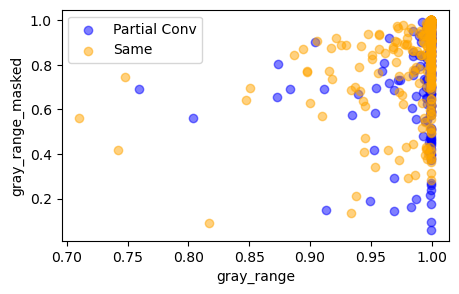

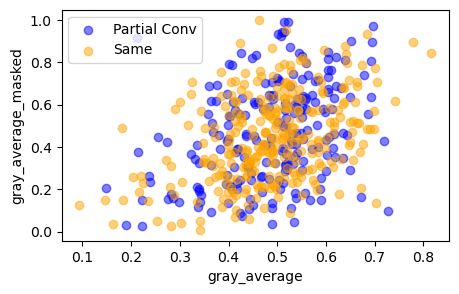

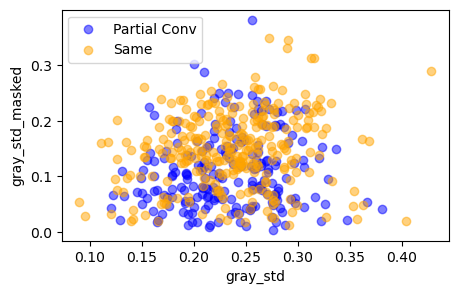

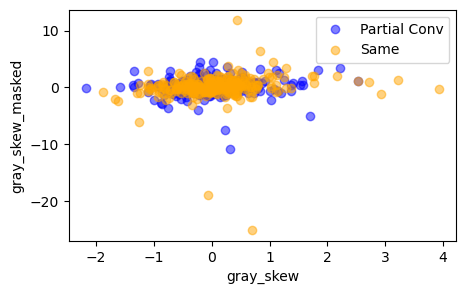

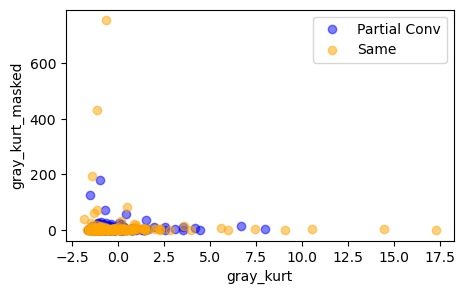

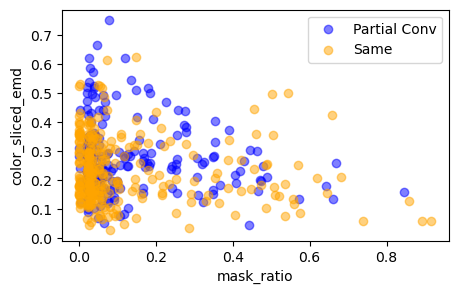

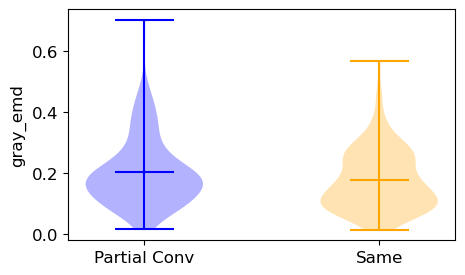

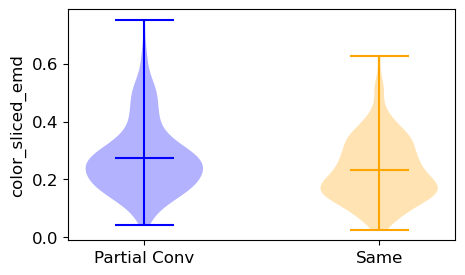

Average gray_emd Partial Conv: 0.203109659865572
Average gray_emd Same: 0.17646159548841073
Average color_sliced_emd Partial Conv: 0.2749590213238183
Average color_sliced_emd Same: 0.23224974449804428
Style: style-2.jpg, Partial Conv sliced EMD: 0.3263288071962738, Same sliced EMD: 0.21189810827235586
Style: style-1.jpg, Partial Conv sliced EMD: 0.2530594108902627, Same sliced EMD: 0.3106300085487207
Style: style-10.jpg, Partial Conv sliced EMD: 0.28550554700699715, Same sliced EMD: 0.17450399128454971
Style: style-6.jpg, Partial Conv sliced EMD: 0.2543508863497363, Same sliced EMD: 0.20798209592827138
Style: style-7.jpg, Partial Conv sliced EMD: 0.2659058327026962, Same sliced EMD: 0.2504675539125046
Style: style-0.jpg, Partial Conv sliced EMD: 0.2754990219440577, Same sliced EMD: 0.22380291808522035
Style: style-5.jpg, Partial Conv sliced EMD: 0.2783372507710089, Same sliced EMD: 0.22024763721568344
Style: style-4.jpg, Partial Conv sliced EMD: 0.29022935104820996, Same sliced EMD: 0.

In [55]:
# Make scatter plots of content vs masked regions
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_range", "gray_range_masked")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_average", "gray_average_masked")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_std", "gray_std_masked")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_skew", "gray_skew_masked")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_kurt", "gray_kurt_masked")

makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "mask_ratio", "color_sliced_emd")

# Make violin plots of content vs masked regions
makeViolinPlot(df_pc, df_same, "Partial Conv", "Same", "gray_emd")
makeViolinPlot(df_pc, df_same, "Partial Conv", "Same", "color_sliced_emd")

# Get average gray_emd and color_sliced_emd for each df
avg_gray_emd_pc = df_pc['gray_emd'].mean()
avg_gray_emd_same = df_same['gray_emd'].mean()
avg_color_sliced_emd_pc = df_pc['color_sliced_emd'].mean()
avg_color_sliced_emd_same = df_same['color_sliced_emd'].mean()

print("Average gray_emd Partial Conv:", avg_gray_emd_pc)
print("Average gray_emd Same:", avg_gray_emd_same)
print("Average color_sliced_emd Partial Conv:", avg_color_sliced_emd_pc)
print("Average color_sliced_emd Same:", avg_color_sliced_emd_same)

# Get averages per style
styles = df['style'].unique()
for style in styles:
    df_style = df_same[df_same['style'] == style]
    avg_color_sliced_emd_same = df_style['color_sliced_emd'].mean()

    df_style = df_pc[df_pc['style'] == style]
    avg_color_sliced_emd_pc = df_style['color_sliced_emd'].mean()
    print(f"Style: {style}, Partial Conv sliced EMD: {avg_color_sliced_emd_pc}, Same sliced EMD: {avg_color_sliced_emd_same}")

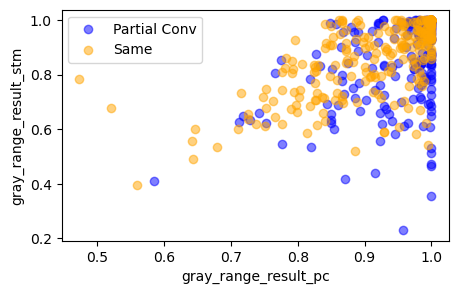

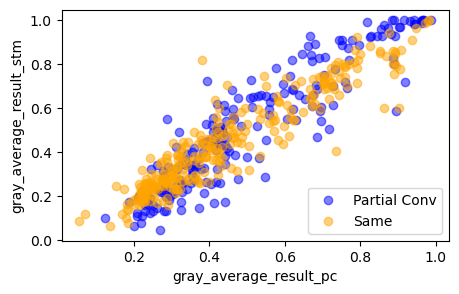

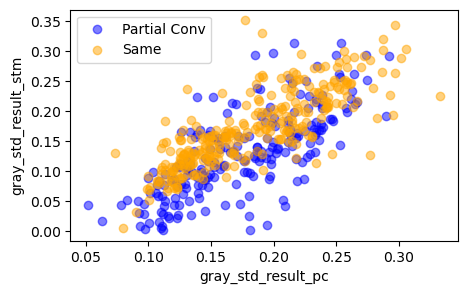

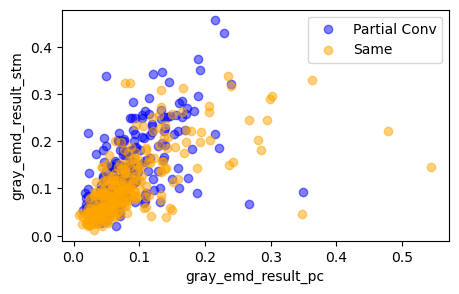

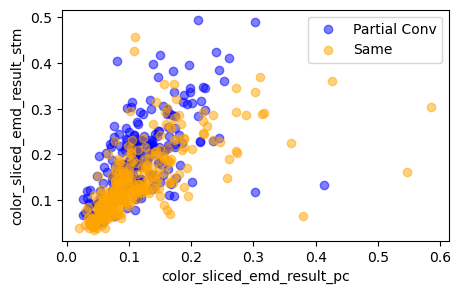

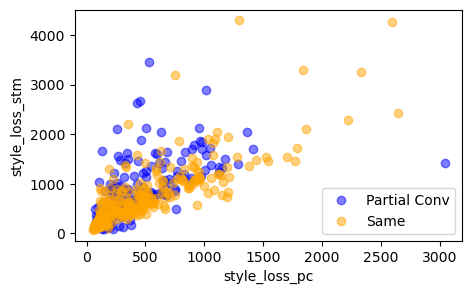

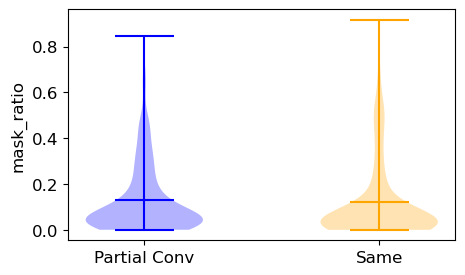

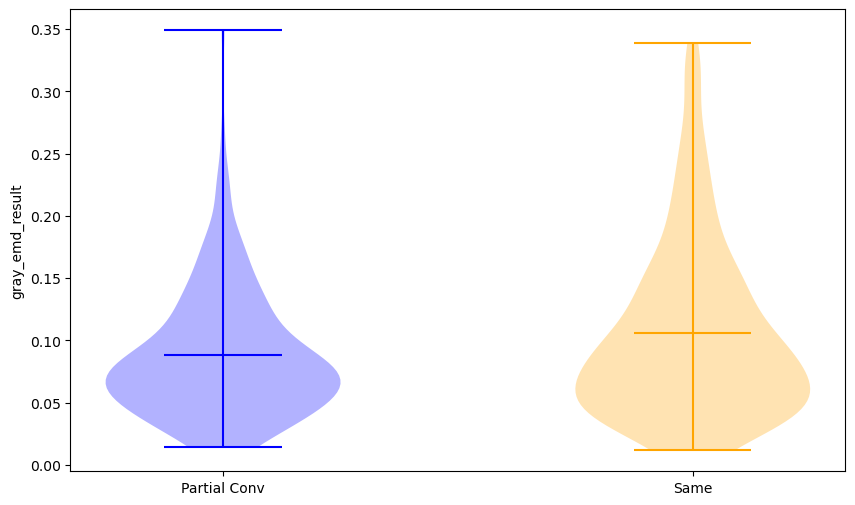

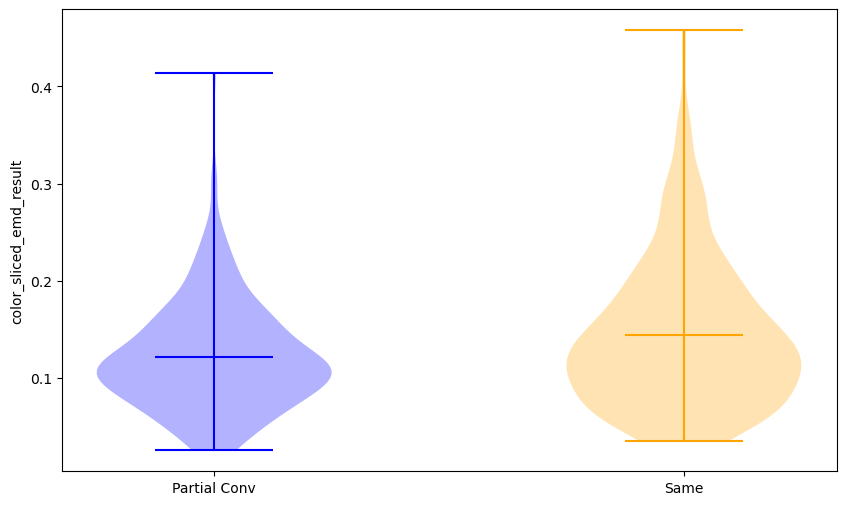

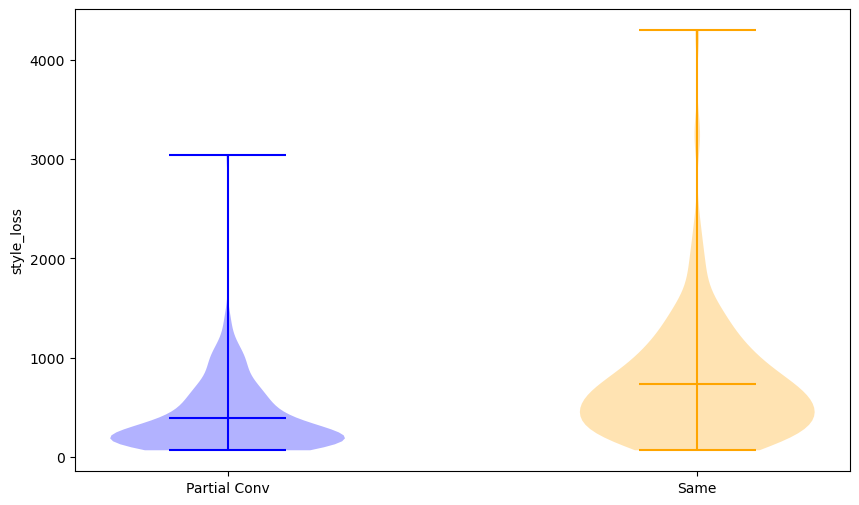

In [56]:
# Make scatter plots of style then mask vs partial conv regions
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_range_result_pc", "gray_range_result_stm")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_average_result_pc", "gray_average_result_stm")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_std_result_pc", "gray_std_result_stm")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "gray_emd_result_pc", "gray_emd_result_stm")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "color_sliced_emd_result_pc", "color_sliced_emd_result_stm")
makeScatterPlot(df_pc, df_same, "Partial Conv", "Same", "style_loss_pc", "style_loss_stm")


# Make violin plots of style then mask vs partial conv regions
makeViolinPlot(df_pc, df_same, "Partial Conv", "Same", "mask_ratio")
makeViolinPlotTwoMetrics(df_pc, df_same, "Partial Conv", "Same", "gray_emd_result_pc", "gray_emd_result_stm", "gray_emd_result")
makeViolinPlotTwoMetrics(df_pc, df_same, "Partial Conv", "Same", "color_sliced_emd_result_pc", "color_sliced_emd_result_stm", "color_sliced_emd_result")
makeViolinPlotTwoMetrics(df_pc, df_same, "Partial Conv", "Same", "style_loss_pc", "style_loss_stm", "style_loss")